# 2 Data Wrangling and Exploratory Data Analysis<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Imports](#2.2_Imports)
  * [2.3 Load Spotify Chart Data](#2.3_Load_Spotify_Chart_Data)
  * [2.4 Load Spotify Track Feature Data](#2.4_Load_Spotify_Track_Feature_Data)
  * [2.5 Explore The Data](#2.5_Explore_The_Data)
    * [2.5.1 Average Streams per Position](#2.5.1_Average_Streams_per_Position)
    * [2.5.2 Categorical Features](#2.5.2_Categorical_Features)
      * [2.5.2.1 Unique Genres](#2.5.2.1_Unique_Genres)
      * [2.5.2.2 Unique Genres](#2.5.2.2_Unique_Decades)
    * [2.5.3 Non-Categorical Features](#2.5.3_Non-Categorical_Features)
      * [2.5.3.1 Numeric Data Summary](#2.5.2.1_Numeric_data_summary)
      * [2.5.3.2 Distributions of Feature Values](#2.5.2.2_Distributions_Of_Feature_Values)

## 2.2 Imports<a id='2.2_Imports'></a>

In [1]:
import pandas as pd
from pathlib import Path
import spotipy
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

## 2.3 Load Spotify Chart Data<a id='2.1_Load_Spotify_Chart_Data'></a>

Spotify chart data is not available in the Spotify API and must be downloaded from https://spotifycharts.com/regional.  Each week has it's own .csv file and has been downloaded to a folder for this project.  We will use python to combine and clean this data so that we can link it to track data in the Spotify API via 'track id.'

In [2]:
source_files = sorted(Path(r"C:\Users\ashle\Documents\GitHub\Springboard\Capstone Project 3\Data").glob('*.csv'))

dataframes = []
for file in source_files:
    df = pd.read_csv(file) 
    df['source'] = file.name
    dataframes.append(df)

top_200_tracks = pd.concat(dataframes)
top_200_tracks.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Note that these figures are generated using a formula that protects against any artificial inflation of chart positions.,Unnamed: 4,source
0,Position,Track Name,Artist,Streams,URL,regional-global-weekly-2020-03-06--2020-03-13.csv
1,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv
2,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv
3,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv
4,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv


In [3]:
missing = pd.concat([top_200_tracks.isnull().sum(), 100 * top_200_tracks.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Unnamed: 0,0,0.0
Unnamed: 1,0,0.0
Unnamed: 2,0,0.0
Note that these figures are generated using a formula that protects against any artificial inflation of chart positions.,0,0.0
Unnamed: 4,0,0.0
source,0,0.0


There are no missing values in the data set but due to the csv formatting, the column names don't make sense.  By refering the head data above, we can create a dictionary to map the current column names to the appropriate column names.

In [4]:
top_200_tracks.rename(columns = {'Unnamed: 0':'Position','Unnamed: 1':'Track Name','Unnamed: 2':'Artist','Note that these figures are generated using a formula that protects against any artificial inflation of chart positions.':'Stream Count/Week','Unnamed: 4':'URL'}, inplace = True) 
top_200_tracks.head()

,Position,Track Name,Artist,Stream Count/Week,URL,source
0,Position,Track Name,Artist,Streams,URL,regional-global-weekly-2020-03-06--2020-03-13.csv
1,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv
2,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv
3,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv
4,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv


Now that the column names have been fixed, we can assume there is a row from each file with the column names listed that should not be included in the data set.  We are looking to have 52 files with 200 tracks each.  This means we should have 10,400 rows. Once we remove the extra header lines, we will check to see if we have the correct number of lines.  If the lines are divisible by 200 then we will need to check the source folder for extra/missing files.  If the lines don't tie and aren't divisible by 200, we can assume there are additional rows that need to be removed from the data set.

In [5]:
top_200_tracks.drop(top_200_tracks[top_200_tracks['Position'] == 'Position'].index, inplace = True) 
top_200_tracks.head()

,Position,Track Name,Artist,Stream Count/Week,URL,source
1,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv
2,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv
3,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv
4,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv
5,5,La Difícil,Bad Bunny,29598307,https://open.spotify.com/track/6NfrH0ANGmgBXyx...,regional-global-weekly-2020-03-06--2020-03-13.csv


In [6]:
top_200_tracks.shape

(10600, 6)

We have 200 more lines than we had expected to see.  The file names include the beginning and ending dates of each week.  Let's create a new column for the week ending date to see if we can identify where the extra 200 rows are coming from.

In [7]:
top_200_tracks['Week Ending'] = top_200_tracks.source.str[35:45]
top_200_tracks.head()

,Position,Track Name,Artist,Stream Count/Week,URL,source,Week Ending
1,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13
2,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13
3,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13
4,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13
5,5,La Difícil,Bad Bunny,29598307,https://open.spotify.com/track/6NfrH0ANGmgBXyx...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13


In [8]:
top_200_tracks['Week Ending'].unique()

array(['2020-03-13', '2020-03-20', '2020-03-27', '2020-04-03',
       '2020-04-10', '2020-04-17', '2020-04-24', '2020-05-01',
       '2020-05-08', '2020-05-15', '2020-05-22', '2020-05-29',
       '2020-06-05', '2020-06-12', '2020-06-19', '2020-06-26',
       '2020-07-03', '2020-07-10', '2020-07-17', '2020-07-24',
       '2020-07-31', '2020-08-07', '2020-08-14', '2020-08-21',
       '2020-08-28', '2020-09-04', '2020-09-11', '2020-09-18',
       '2020-09-25', '2020-10-02', '2020-10-09', '2020-10-16',
       '2020-10-23', '2020-10-30', '2020-11-06', '2020-11-13',
       '2020-11-20', '2020-11-27', '2020-12-04', '2020-12-11',
       '2020-12-18', '2020-12-25', '2021-01-01', '2021-01-08',
       '2021-01-22', '2021-01-29', '2021-02-05', '2021-02-12',
       '2021-02-19', '2021-02-26', '2021-03-05', '2021-03-12',
       '2021-03-19'], dtype=object)

It appears we downloaded an additional week's worth of data and did not duplicate any weeks in the folder since we have 53 unique week ending dates.  An additional week will help with the modelling so we will leaving the data as is.

Next, we know we need a field with the track id by itself to link to the data in the Spotify API.  Every URL starts the same way and the last set of characters are the track id.  By creating a new column and slicing out the first 31 characters, we should be able to separate out the track id.  We can make sure the slice is correct by comparing to the URL column.

In [9]:
top_200_tracks['id'] = top_200_tracks.URL.str[31:]
top_200_tracks.head()

,Position,Track Name,Artist,Stream Count/Week,URL,source,Week Ending,id
1,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,0sf12qNH5qcw8qpgymFOqD
2,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,0nbXyq5TXYPCO7pr3N8S4I
3,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,1rgnBhdG2JDFTbYkYRZAku
4,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,6WrI0LAC5M1Rw2MnX2ZvEg
5,5,La Difícil,Bad Bunny,29598307,https://open.spotify.com/track/6NfrH0ANGmgBXyx...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,6NfrH0ANGmgBXyxgV2PeXt


## 2.4 Load Spotify API Data<a id='2.1_Load_Spotify_API_Data'></a>

Now that we have the list of all top 200 songs over the past 53 weeks, we can take those track id's to pull their features out of the Spoitfy API.

In [10]:
from spotipy.oauth2 import SpotifyClientCredentials 
import time

client_id = "0054a24f2fc643c69d56d020dd5f70be"
client_secret = "98b4a4b772ad4eca934a92ca60c246a0"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [11]:
track_list = list(set(top_200_tracks['id']))

In [12]:
print(len(track_list))
print(track_list)

1193
['2SxR5RitJdsG6wINvJLBSD', '5jbDih9bLGmI8ycUKkN5XA', '3nAp4IvdMPPWEH9uuXFFV5', '2t7D3y0jvYjR8IP9Bosyew', '4tyX1rw9X309WkEdh2As4B', '70rFIfYN7lU6iTgUIVP42w', '0osvOdeD3YXZiWkT8MKolJ', '0AUvWawuP0ibk4SQ3sIZjk', '2n7ohqg1s68ToAHh4u9mcW', '2Z8yfpFX0ZMavHkcIeHiO1', '0v1x6rN6JHRapa03JElljE', '46mT9NR7N9Zf5MolcrBgE3', '38RIEav39FGi86jppxO0du', '3Ghyp3X5Ua9ypHnBIgOObI', '2n7Ao4nyESBa5ti8gcAbBt', '7o4gBbTM6UBLkOYPw9xMCz', '7vTspUAmMKFkUpKL9HLZNL', '0rqY8g1Y1zaA4YwU6vhBQg', '2TH65lNHgvLxCKXM3apjxI', '71FrGl0XcpL3VId65tB5mg', '14wf185UxfNbSy8dwt4r4q', '6Qs4SXO9dwPj5GKvVOv8Ki', '4jVBIpuOiMj1crqd8LoCrJ', '3QiAAp20rPC3dcAtKtMaqQ', '7aGyRfJWtLqgJaZoG9lJhE', '6i7zAdNhzUN2k1HcrBxPHG', '7qmnP8Woc47dLSrMD5MxL1', '2uFaJJtFpPDc5Pa95XzTvg', '6Gg1gjgKi2AK4e0qzsR7sd', '4EivmOT13NMpNSfTKn9p4s', '2iUXsYOEPhVqEBwsqP70rE', '4TOmcZvw0gHa7GiXRbcYAW', '2tFwfmceQa1Y6nRPhYbEtC', '7MSYSOobsombc1mbDWFxtD', '3H7ihDc1dqLriiWXwsc2po', '6sPBi0qLI6KM3yXX56NxsA', '1uA914Md6wsy9NDryyBypH', '463CkQjx2Zk1yXoBuierM9', '5u1n1

In [13]:
def getTrackFeatures(track_list):
  meta = sp.track(track_list)
  features = sp.audio_features(track_list)
    
  # meta
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']

  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']

  track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
  return track
#Loop over tracks and apply the function
#We’ll now loop over the tracks — applying the function we created— and save the dataset to a .csv file using pandas.

# loop over track ids 
tracks = []
for i in range(len(track_list)):
  time.sleep(.5)
  track = getTrackFeatures(track_list[i])
  tracks.append(track)

# create dataset
track_features = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
track_features.to_csv("spotify.csv", sep = ',')

In [14]:
track_features.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Tunnel Vision (Outro),Shoot For The Stars Aim For The Moon,Pop Smoke,2020-07-03,132587,63,0.718,0.36300,0.660,0.000000,0.159,-7.390,0.3250,142.879,4
1,Perfect,No Pressure,Logic,2020-07-24,100291,72,0.769,0.00948,0.829,0.000067,0.301,-5.228,0.0661,159.943,4
2,Underneath the Tree,Wrapped In Red,Kelly Clarkson,2013-10-25,229640,63,0.509,0.00130,0.812,0.000020,0.214,-5.438,0.0537,159.876,4
3,GO (feat. Juice WRLD),GO (feat. Juice WRLD),The Kid LAROI,2020-06-12,183947,69,0.544,0.18500,0.744,0.000000,0.336,-5.007,0.0889,73.699,4
4,coney island (feat. The National),evermore,Taylor Swift,2020-12-10,275320,60,0.529,0.82600,0.536,0.000820,0.141,-11.269,0.0627,107.873,4


Now that we have pulled all of the features for those tracks, we need to add the track id back to the data set for linking back to the top 200 lists.

In [15]:
track_features['id'] = track_list 

In [16]:
track_features.set_index(['id'])

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
id,,,,,,,,,,,,,,,
2SxR5RitJdsG6wINvJLBSD,Tunnel Vision (Outro),Shoot For The Stars Aim For The Moon,Pop Smoke,2020-07-03,132587,63,0.718,0.36300,0.660,0.000000,0.1590,-7.390,0.3250,142.879,4
5jbDih9bLGmI8ycUKkN5XA,Perfect,No Pressure,Logic,2020-07-24,100291,72,0.769,0.00948,0.829,0.000067,0.3010,-5.228,0.0661,159.943,4
3nAp4IvdMPPWEH9uuXFFV5,Underneath the Tree,Wrapped In Red,Kelly Clarkson,2013-10-25,229640,63,0.509,0.00130,0.812,0.000020,0.2140,-5.438,0.0537,159.876,4
2t7D3y0jvYjR8IP9Bosyew,GO (feat. Juice WRLD),GO (feat. Juice WRLD),The Kid LAROI,2020-06-12,183947,69,0.544,0.18500,0.744,0.000000,0.3360,-5.007,0.0889,73.699,4
4tyX1rw9X309WkEdh2As4B,coney island (feat. The National),evermore,Taylor Swift,2020-12-10,275320,60,0.529,0.82600,0.536,0.000820,0.1410,-11.269,0.0627,107.873,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7x4ASXYEKfQBCewcZhK776,"Ay, DiOs Mío!","Ay, DiOs Mío!",KAROL G,2020-07-10,189653,85,0.718,0.51200,0.712,0.001210,0.1040,-4.366,0.1740,180.034,4
2DhNdoHxavs7Qtf5MnhZD0,EN CASITA,LAS QUE NO IBAN A SALIR,Bad Bunny,2020-05-10,176440,64,0.779,0.22100,0.764,0.000669,0.0909,-8.217,0.0938,158.093,4
58wyJLv6yH1La9NIZPl3ne,Can We Kiss Forever?,Can We Kiss Forever?,Kina,2018-08-31,187931,82,0.522,0.89400,0.128,0.026000,0.0941,-18.717,0.0357,109.986,4


In [17]:
track_features.shape

(1193, 16)

We have everything we need to merge the data sets for analysis.

In [18]:
top_200_features = pd.merge(top_200_tracks, track_features,
how='left', on='id')

In [19]:
top_200_features.head()

,Position,Track Name,Artist,Stream Count/Week,URL,source,Week Ending,id,name,album,...,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,1,Blinding Lights,The Weeknd,41066317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,0sf12qNH5qcw8qpgymFOqD,Blinding Lights,Blinding Lights,...,30,0.513,0.00147,0.796,0.000209,0.0938,-4.075,0.0629,171.017,4
1,2,The Box,Roddy Ricch,37470185,https://open.spotify.com/track/0nbXyq5TXYPCO7p...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,...,88,0.896,0.10400,0.586,0.000000,0.7900,-6.687,0.0559,116.971,4
2,3,Dance Monkey,Tones And I,36071262,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,1rgnBhdG2JDFTbYkYRZAku,Dance Monkey,Dance Monkey,...,69,0.825,0.68800,0.593,0.000161,0.1700,-6.401,0.0988,98.078,4
3,4,Don't Start Now,Dua Lipa,32169572,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,6WrI0LAC5M1Rw2MnX2ZvEg,Don't Start Now,Don't Start Now,...,85,0.794,0.01250,0.793,0.000000,0.0952,-4.521,0.0842,123.941,4
4,5,La Difícil,Bad Bunny,29598307,https://open.spotify.com/track/6NfrH0ANGmgBXyx...,regional-global-weekly-2020-03-06--2020-03-13.csv,2020-03-13,6NfrH0ANGmgBXyxgV2PeXt,La Difícil,YHLQMDLG,...,81,0.685,0.08610,0.848,0.000007,0.0783,-4.561,0.0858,179.870,4


In [20]:
top_200_features.to_csv('top_200_tracks_features.csv')

In [21]:
top_200_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10600 entries, 0 to 10599
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Position           10600 non-null  object 
 1   Track Name         10600 non-null  object 
 2   Artist             10600 non-null  object 
 3   Stream Count/Week  10600 non-null  object 
 4   URL                10600 non-null  object 
 5   source             10600 non-null  object 
 6   Week Ending        10600 non-null  object 
 7   id                 10600 non-null  object 
 8   name               10600 non-null  object 
 9   album              10600 non-null  object 
 10  artist             10600 non-null  object 
 11  release_date       10600 non-null  object 
 12  length             10600 non-null  int64  
 13  popularity         10600 non-null  int64  
 14  danceability       10600 non-null  float64
 15  acousticness       10600 non-null  float64
 16  energy             106

Based upon the info above, it looks like we need to reformat a few columns - Position, Stream Count/Week, Week Ending, and release_date.  By changing these fields to number or dates, it will allow us to get more analysis out of those fields.

In [22]:
top_200_features["Position"] = pd.to_numeric(top_200_features["Position"])
top_200_features["Stream Count/Week"] = pd.to_numeric(top_200_features["Stream Count/Week"])
top_200_features["Week Ending"] = pd.to_datetime(top_200_features["Week Ending"])
top_200_features["release_date"] = pd.to_datetime(top_200_features["release_date"])

In [23]:
top_200_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10600 entries, 0 to 10599
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Position           10600 non-null  int64         
 1   Track Name         10600 non-null  object        
 2   Artist             10600 non-null  object        
 3   Stream Count/Week  10600 non-null  int64         
 4   URL                10600 non-null  object        
 5   source             10600 non-null  object        
 6   Week Ending        10600 non-null  datetime64[ns]
 7   id                 10600 non-null  object        
 8   name               10600 non-null  object        
 9   album              10600 non-null  object        
 10  artist             10600 non-null  object        
 11  release_date       10600 non-null  datetime64[ns]
 12  length             10600 non-null  int64         
 13  popularity         10600 non-null  int64         
 14  dancea

## 2.5 Explore the Data<a id='2.5_Explore_The_Data'></a>

### 2.5.1 Average Streams per Position<a id='2.5.1_Average_Streams_per_Position'></a>

While we would like to predict the chart position of a song, we will do so indirectly.  By understanding the averages of streams in each chart position, we can infer the chart position based upon the amount of streams we will forecast in our time series forecast.  

In [24]:
top_200_features.groupby(['Position'])['Stream Count/Week'].describe()

,count,mean,std,min,25%,50%,75%,max
Position,,,,,,,,
1,53.0,4.226770e+07,8.627148e+06,31544941.0,37363418.0,40267123.0,45847200.0,80764045.0
2,53.0,3.409511e+07,4.832902e+06,23461354.0,30463204.0,33897676.0,36899304.0,48011162.0
3,53.0,3.066208e+07,4.017041e+06,22418356.0,28540616.0,30727192.0,33715483.0,38503261.0
4,53.0,2.824718e+07,3.402336e+06,21761667.0,26145345.0,28367431.0,30596452.0,38006961.0
5,53.0,2.626384e+07,3.113873e+06,19989826.0,24320342.0,26181061.0,27982035.0,37323134.0
...,...,...,...,...,...,...,...,...
196,53.0,4.712784e+06,3.899717e+05,4244510.0,4427619.0,4598325.0,4894734.0,6286261.0
197,53.0,4.698442e+06,3.879080e+05,4218201.0,4423039.0,4582940.0,4886940.0,6278993.0
198,53.0,4.690774e+06,3.861216e+05,4209179.0,4407901.0,4570806.0,4867644.0,6264613.0


In [25]:
top_200_avg = pd.DataFrame(top_200_features.groupby(['Position'])['Stream Count/Week'].describe())
top_200_avg.head()

,count,mean,std,min,25%,50%,75%,max
Position,,,,,,,,
1,53.0,4.226770e+07,8.627148e+06,31544941.0,37363418.0,40267123.0,45847200.0,80764045.0
2,53.0,3.409511e+07,4.832902e+06,23461354.0,30463204.0,33897676.0,36899304.0,48011162.0
3,53.0,3.066208e+07,4.017041e+06,22418356.0,28540616.0,30727192.0,33715483.0,38503261.0
4,53.0,2.824718e+07,3.402336e+06,21761667.0,26145345.0,28367431.0,30596452.0,38006961.0
5,53.0,2.626384e+07,3.113873e+06,19989826.0,24320342.0,26181061.0,27982035.0,37323134.0


### 2.5.2 Numerical Features<a id='2.5.2_Categorical_Features'></a>

#### 2.5.2.1 Numerical Features Summary<a id='2.5.2.1_Numerical_Features_Summary'></a>

In [26]:
top_200_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Position,10600.0,1.005000e+02,5.773703e+01,1.000000e+00,5.075000e+01,1.005000e+02,1.502500e+02,2.000000e+02
Stream Count/Week,10600.0,8.921558e+06,5.755914e+06,4.176083e+06,5.424752e+06,6.819002e+06,1.026018e+07,8.076404e+07
length,10600.0,1.992996e+05,4.011959e+04,3.058200e+04,1.726920e+05,1.975860e+05,2.190480e+05,4.841460e+05
popularity,10600.0,7.988500e+01,1.299755e+01,0.000000e+00,7.700000e+01,8.300000e+01,8.700000e+01,1.000000e+02
danceability,10600.0,7.000411e-01,1.371088e-01,1.500000e-01,6.170000e-01,7.250000e-01,8.010000e-01,9.800000e-01
acousticness,10600.0,2.617697e-01,2.568960e-01,2.550000e-05,5.500000e-02,1.800000e-01,3.927500e-01,9.940000e-01
energy,10600.0,6.174313e-01,1.587290e-01,1.030000e-01,5.237500e-01,6.310000e-01,7.300000e-01,9.700000e-01
instrumentalness,10600.0,8.816951e-03,6.223752e-02,0.000000e+00,0.000000e+00,0.000000e+00,3.330000e-05,9.530000e-01
liveness,10600.0,1.691646e-01,1.297311e-01,3.110000e-02,9.260000e-02,1.210000e-01,2.000000e-01,9.620000e-01
loudness,10600.0,-6.245065e+00,2.355260e+00,-2.250700e+01,-7.398000e+00,-5.884000e+00,-4.596000e+00,1.509000e+00


#### 2.5.2.2 Distribution of Feature Values<a id='2.5.2.2_Distribution_of_Feature_Values'></a>

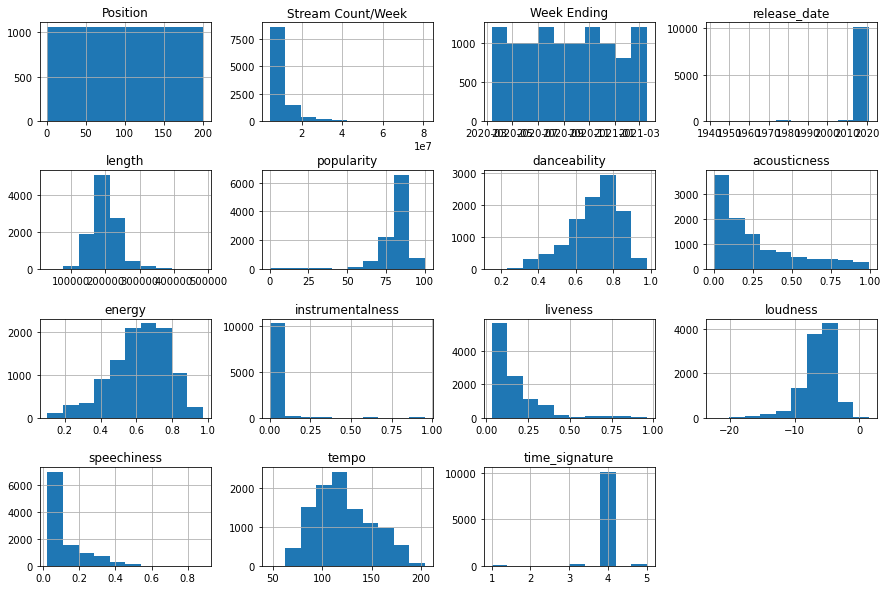

In [27]:
#Call `hist` method to plot histograms of each of the numeric features
top_200_features.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)


#### 2.5.2.3 Feature Correlation Heatmap<a id='2.5.2.3_Feature_Correlation_Heatmap'></a>

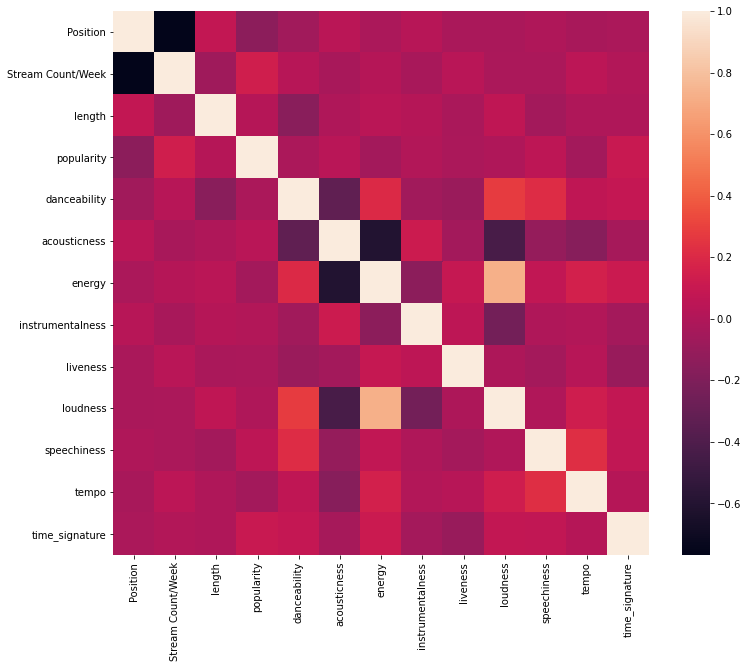

In [28]:
plt.subplots(figsize=(12,10))
sns.heatmap(top_200_features.corr());

We'll run a full correlation analysis but there appears a strong correlation between energy and loudness indicating we don't want to include both features in the regression.

In [29]:
#stack the matrix
top_200_corr=top_200_features.corr(method ='pearson') 
top_200_corr1 = top_200_corr.stack().reset_index()

#set column names
top_200_corr1.columns = ['variable_1','variable_2','correlation_coefficient']

# create a mask to identify rows with duplicate features as mentioned above
mask_dups = (top_200_corr1[['variable_1', 'variable_2']].apply(frozenset, axis=1).duplicated()) | (top_200_corr1['variable_1']==top_200_corr1['variable_2']) 

# apply the mask to clean the correlation dataframe
top_200_corr1 = top_200_corr1[~mask_dups]

# create a list of our conditions for correlation_class
conditions = [
    (top_200_corr1['correlation_coefficient'] > 0.6),
    (top_200_corr1['correlation_coefficient'] <= 0.6) & (top_200_corr1['correlation_coefficient'] > 0.4),
    (top_200_corr1['correlation_coefficient'] <= 0.4)
    ]

# create a list of the values we want to assign for each condition
values = ['HIGH', 'MID', 'LOW']

# create a new column and use np.select to assign values to it using our lists as arguments
top_200_corr1['correlation_class'] = np.select(conditions, values)

# display updated DataFrame
top_200_corr1.head()

,variable_1,variable_2,correlation_coefficient,correlation_class
1,Position,Stream Count/Week,-0.766714,LOW
2,Position,length,0.079684,LOW
3,Position,popularity,-0.138926,LOW
4,Position,danceability,-0.062000,LOW
5,Position,acousticness,0.041503,LOW


In [30]:
top_200_corr1.to_csv('./spotify_top_200_features_correlation_data.csv')

#### 2.5.2.4 Scatterplots of Numeric Features Against Position<a id='2.5.2.3_Feature_Correlation_Heatmap'></a>

##### Length

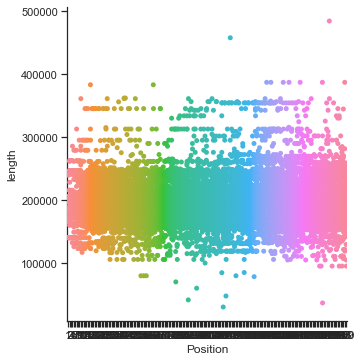

In [31]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['length'], data=top_200_features)

##### Popularity

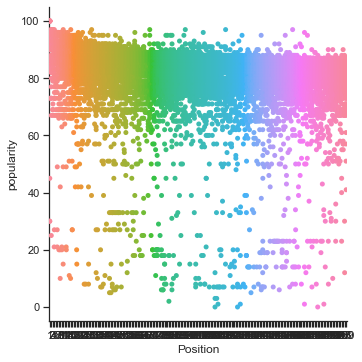

In [32]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['popularity'], data=top_200_features)

##### Danceability

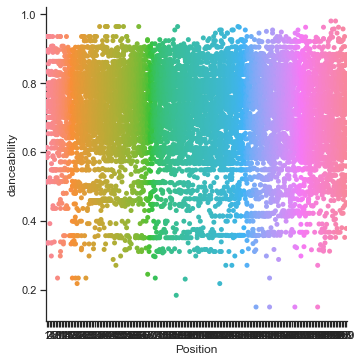

In [33]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['danceability'], data=top_200_features)

##### Acousticness

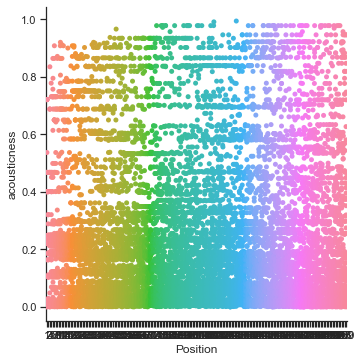

In [34]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['acousticness'], data=top_200_features)

##### Energy

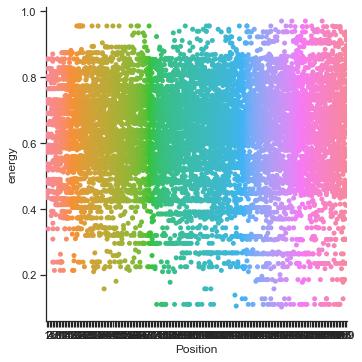

In [35]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['energy'], data=top_200_features)

##### Instrumentalness

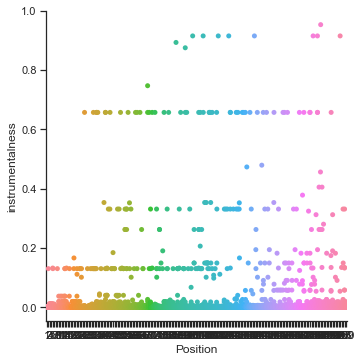

In [36]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['instrumentalness'], data=top_200_features)

##### Liveness

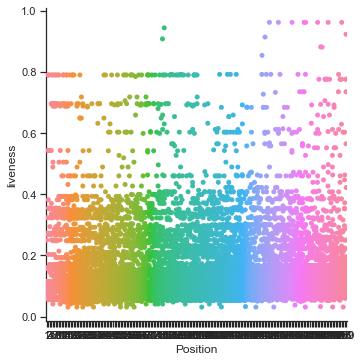

In [37]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['liveness'], data=top_200_features)

##### Loudness

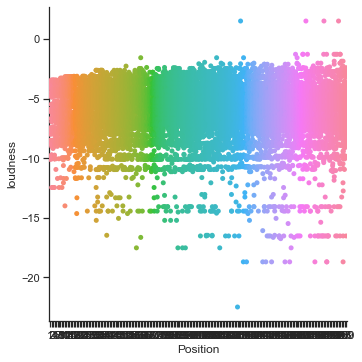

In [38]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['loudness'], data=top_200_features)

##### Speechiness

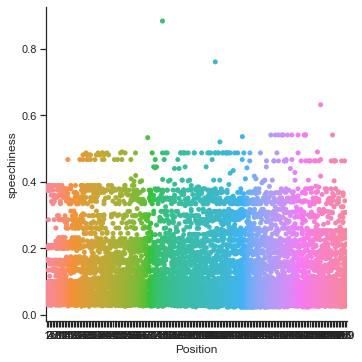

In [39]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['speechiness'], data=top_200_features)

##### Tempo

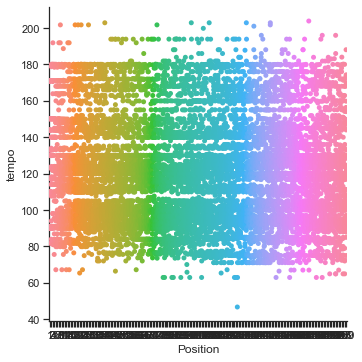

In [40]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['tempo'], data=top_200_features)

##### Time Signature

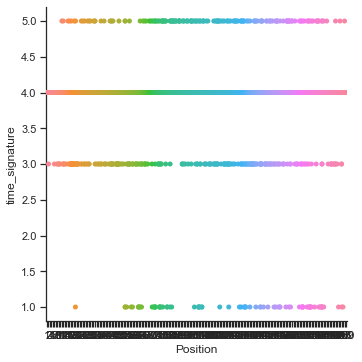

In [41]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x = top_200_features['Position'], y = top_200_features['time_signature'], data=top_200_features)